## Building The Algorithm

Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

### Importing Preprocessed Data

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp_processed.csv")

print(df_tmp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int64(54)
memory usage: 197.6 MB
None


In [5]:
# Instantiate  a model to train on all computer processors available
model = RandomForestRegressor(n_jobs=1)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

RandomForestRegressor(n_jobs=1)

In [6]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp.SalePrice)

0.987575164218865

###### model scored a 98 percent accuracy because it was evaluated on the same dataset it was trained on.  so this metric is not reliable we have to split the data into trainining and validation sets

### Splitting data into train/valid sets


According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the train set, validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

In [7]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [8]:
# Split our data into train and validation splits

df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp["saleYear"] != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [9]:
# Split the data into X and y train and test splits

X_train, y_train = (df_train.drop("SalePrice", axis=1), df_train["SalePrice"])
X_valid, y_valid = (df_val.drop("SalePrice", axis=1), df_val["SalePrice"])

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they want is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.
Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

MAE and R^2 was also calculated for this project for fun., Most of the time, you might want to build your evaluation functions from the scratch that is what is below

In [16]:
# Create evaluation function (the competion uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
import numpy as np

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create a function to evaluate the model at all levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    
    scores = {"Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, valid_preds),
              "Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, valid_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^s": r2_score(y_valid, valid_preds)}
    return scores

### Testing our Model on a Subset  of the Data (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to, So what I will do is take a sample of the training set and tune the hyperparameters on that before training a larger model.
Making calculations on ~400,000 rows may take a while...
Let's alter the number of samples each `n_estimator` in the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) sees using the `max_samples` parameter.

Setting `max_samples` to 10000 means every `n_estimator` in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [14]:
%%time

# Instantiate another model with max samples changed
model = RandomForestRegressor(n_jobs=-1, max_samples=10000)
model.fit(X_train, y_train)

Wall time: 16.3 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [17]:
show_scores(model)

{'Training RMSLE': 0.2578706135227991,
 'Valid RMSLE': 0.29404238049146225,
 'Training MAE': 5552.213691392955,
 'Valid MAE': 7151.219599066793,
 'Training R^2': 0.8609243524312267,
 'Valid R^s': 0.8334741675446795}

###### We can see that the experiment took far less time than the model with all the data. With this, we can tune some of the  model's hyperparameters.



### Hyperparameter tuning with RandomizedSearchCV

In [18]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 44min 28s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [19]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 12,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [20]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training RMSLE': 0.2675792646332636,
 'Valid RMSLE': 0.30015136587294833,
 'Training MAE': 5841.503860918104,
 'Valid MAE': 7440.497454683155,
 'Training R^2': 0.8442470490409576,
 'Valid R^s': 0.815601378848539}

### Train a model with the best Hyperparameters

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [22]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=30, 
                                    min_samples_leaf=3, 
                                    min_samples_split=12, 
                                    max_features='auto', 
                                    n_jobs=-1, 
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 1min 46s


RandomForestRegressor(min_samples_leaf=3, min_samples_split=12, n_estimators=30,
                      n_jobs=-1, random_state=42)

In [23]:
show_scores(ideal_model)

{'Training RMSLE': 0.14525713716696204,
 'Valid RMSLE': 0.252633914715241,
 'Training MAE': 2895.7916475295438,
 'Valid MAE': 6099.198660515082,
 'Training R^2': 0.9572045043912253,
 'Valid R^s': 0.8722112009983322}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

In [24]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=20,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

Wall time: 40.6 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=20,
                      n_jobs=-1)

In [25]:
show_scores(fast_model)

{'Training RMSLE': 0.13209539959560598,
 'Valid RMSLE': 0.24768213800567096,
 'Training MAE': 2603.036036276736,
 'Valid MAE': 6034.112244518457,
 'Training R^2': 0.9656324677422974,
 'Valid R^s': 0.8782128342766774}

### Make Predictions on Test Data

> Now we've got a trained model, it's time to make predictions on the test data. Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012. So what we're doing is trying to use the patterns our model has learnt in the training data to predict the sale price of a Bulldozer it has never seen before but with characteristics assumed to be similar to that of those in the training data.


### Importing The Test Data

In [26]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", parse_dates =["saledate"], low_memory=False)

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the Data

In order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data. an we will achieve this by creating function which copies the preprocessing steps for the training dataset.

**Note:** This function could break if the training set has a different missing value from the test set.

In [27]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

In [30]:
# Preprocess the data

df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [31]:
# Compare with X_train
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


test set(df_test) has 101 columns while train set (X_train) which our model was trained on has 102 columns, This means our model cannot make predictions on them. Therefore we have to find the difference between the two and solve the problem 

In [34]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'saleDayOfWeek', 'saleDayOfYear'}

In this case, it's because the test dataset wasn't missing any `auctioneerID` fields.

To fix it, we'll add a column to the test dataset called `auctioneerID_is_missing` and fill it with `False`, since none of the `auctioneerID` fields are missing in the test dataset.

In [39]:
# Match test dataset columns to training dataset
# df_test["auctioneerID_is_missing"] = False
df_test.tail()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,True,True,True,True,True,False
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,True,True,True,True,True,False
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,True,True,True,True,True,False
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,True,True,True,True,True,False
12456,6643196,2558346,21446,149,2,2008,3525.0,0,483,171,...,False,False,False,False,True,True,True,True,True,False


In [40]:
# Make predictions on the test dataset using the best model as the  test data now matches train data
test_preds = ideal_model.predict(df_test)

In [41]:
# Create  A New DataFrame to Present Results
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,19762.245113
1,1227844,20573.828766
2,1227847,46980.295179
3,1227848,86307.755240
4,1227863,41502.440844
...,...,...
12452,6643171,58154.317692
12453,6643173,11478.008088
12454,6643184,13154.326456
12455,6643186,16339.445463


In [42]:
# Export Predictions to csv...
df_preds.to_csv("predictions.csv", index=False)

### Feature Importance

Feature Importance seeks to figure out which different attributes of the data were of the most importance to the model after training when it comes to predicting the **target variable** (SalePrice)

**Note** The default feature importances for random forests can lead to non-ideal results

In [43]:
# RandomForest Model Feature Importance
ideal_model.feature_importances_

array([4.65071876e-02, 1.19992638e-02, 3.27585236e-02, 1.61798256e-04,
       2.93411092e-03, 2.71846348e-01, 2.35189974e-03, 8.25329355e-04,
       1.95356463e-02, 7.89209065e-02, 5.33337700e-02, 4.26383273e-03,
       3.23256336e-03, 2.36967699e-01, 4.01755880e-02, 6.01758578e-03,
       1.54198396e-04, 2.01240863e-04, 1.73509042e-03, 8.58552300e-03,
       2.32866323e-04, 2.32031536e-05, 4.07280284e-04, 1.60260331e-04,
       1.60836374e-03, 1.13231371e-05, 5.34724768e-04, 8.20234222e-03,
       1.07458513e-04, 1.46312380e-05, 2.53465325e-03, 1.83954610e-03,
       2.07551228e-03, 3.85218377e-03, 1.52901495e-04, 1.51792434e-03,
       7.50622820e-04, 1.86341932e-02, 4.41115515e-06, 1.03526862e-06,
       1.36860729e-04, 8.32792461e-04, 9.98834428e-04, 5.34209555e-04,
       1.65978325e-04, 2.66861715e-04, 1.99779516e-04, 1.33352015e-03,
       8.01757781e-04, 1.11912069e-04, 1.71077011e-04, 7.80914755e-02,
       1.87862361e-03, 5.81532304e-03, 2.70314640e-03, 1.17924501e-02,
      

In [50]:
# Plotting Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_features(columns, importances, n=20):
    # Pandas chaining (dataframe + pandas functions)
    df = (pd.DataFrame({"features": columns, 
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot the DataFrame
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:20])
    ax.set(xlabel="Feature Importance", ylabel="Feature")
    ax.invert_yaxis()

In [48]:
features = pd.DataFrame({"features":X_train.columns, "feature_importance": ideal_model.feature_importances_})
features.sort_values("feature_importance", inplace=True, ascending=False)
features.head(30)

,features,feature_importance
5,YearMade,0.271846
13,ProductSize,0.236968
9,fiBaseModel,0.078921
51,saleYear,0.078091
10,fiSecondaryDesc,0.053334
0,SalesID,0.046507
14,fiProductClassDesc,0.040176
2,ModelID,0.032759
8,fiModelDesc,0.019536
37,Coupler_System,0.018634


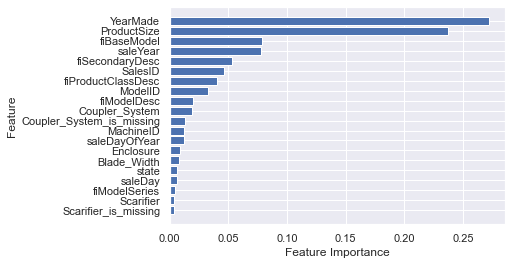

In [51]:
plot_features(X_train.columns, ideal_model.feature_importances_);